<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/Model_Training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets -qq
!pip install evaluate -qq
!pip install albumentations -qq
!pip install git+https://github.com/huggingface/transformers.git -qq
# We will use this to push our trained model to HF Hub
!pip install huggingface_hub -qq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)
import evaluate
from huggingface_hub import notebook_login

In [ ]:
# from datasets import load_dataset
# ds = load_dataset("mukesh3444/manual-window-detect", split="train")
# print(ds[0])

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mukesh3444/manual-window-detect contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mukesh3444/manual-window-detect
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1000x670 at 0x791A14BC3370>, 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=1000x670 at 0x791A14BC11B0>, 'scene_category': 192}


In [ ]:
from datasets import load_dataset
train = load_dataset("scene_parse_150", "instance_segmentation", split="train[:1000]")
validation = load_dataset("scene_parse_150", "instance_segmentation", split="validation[:100]")
test = load_dataset("scene_parse_150", "instance_segmentation", split="test[:10]")

In [ ]:
checkpoint = "facebook/maskformer-swin-small-ade"
print(train)

Dataset({
    features: ['image', 'annotation'],
    num_rows: 1000
})


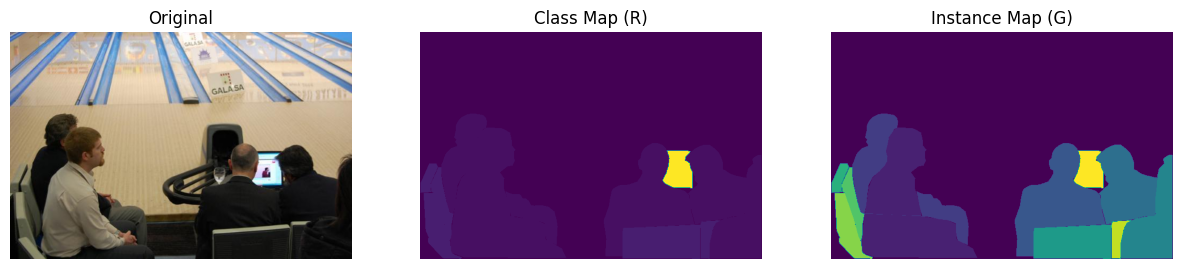

In [ ]:
index = random.randint(0, len(train))
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)
plt.figure(figsize=(15, 5))
for plot_index in range(3):
    if plot_index == 0:
        # If plot index is 0 display the original image
        plot_image = image
        title = "Original"
    else:
        # Else plot the annotation maps
        plot_image = annotation[..., plot_index - 1]
        title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]
    # Plot the image
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

In [ ]:
from transformers import MaskFormerFeatureExtractor
preprocessor = MaskFormerImageProcessor.from_pretrained(checkpoint)
processor = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

print(processor)
#print(processor1)

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

MaskFormerImageProcessor {
  "_max_size": 1333,
  "do_normalize": false,
  "do_reduce_labels": true,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 255,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "MaskFormerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}



/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:410: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:417: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:428: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
from transformers import MaskFormerConfig
config = MaskFormerConfig.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

In [ ]:
model = MaskFormerForInstanceSegmentation(config)
# Replace the randomly initialized model with the pre-trained model weights
base_model = MaskFormerModel.from_pretrained(checkpoint)
model.model = base_model

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
# Get a modified version of the id2label and label2id
data = pd.read_csv(
    "/content/instanceInfo100_train.txt",
    sep="\t",
    header=0,
    on_bad_lines="skip",
)
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
label2id = {v: k for k, v in id2label.items()}
# Edit MaskFormer config labels
config.id2label = id2label
config.label2id = label2id

--2024-01-13 10:23:47--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘instanceInfo100_train.txt.6’

instanceInfo100_tra 100%[===================>]   3.24K  --.-KB/s    in 0s      

2024-01-13 10:23:47 (38.2 MB/s) - ‘instanceInfo100_train.txt.6’ saved [3313/3313]



In [ ]:
# Define the configurations of the transforms specific
# to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
# Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# print(train[0]["annotation"])

# image = np.array(train[1]["image"].convert("RGB"))
# instance_seg = np.array(train[1]["annotation"])[..., 1]
# class_id_map = np.array(train[1]["annotation"])[..., 0]
# class_labels = np.unique(class_id_map)

# print(instance_seg)
# print(class_id_map)
# print(class_labels)
# inst2class = {}

# for label in class_labels:
#       instance_ids = np.unique(instance_seg[class_id_map == label])
#       inst2class.update({i: label for i in instance_ids})
# print(inst2class)

# transformed = train_val_transform(image=image, mask=instance_seg)
# # print(transformed)
# (image, instance_seg) = (transformed["image"], transformed["mask"])

# # print((image, instance_seg))

# # # Convert from channels last to channels first
# # image = image.transpose(2,0,1)

# inputs = processor([image], return_tensors="pt")
# inputs = {k:v.squeeze() for k,v in inputs.items()}
# inputs["class_labels"] = torch.tensor([0])
# inputs["mask_labels"] = torch.zeros(
#     (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
# )

class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        # Initialize the dataset, processor, and transform variables
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        # Return the number of datapoints
        return len(self.dataset)

    def __getitem__(self, idx):
        # Convert the PIL Image to a NumPy array
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        # Get the pixel wise instance id and category id maps
        # of shape (height, width)
        instance_seg = np.array(self.dataset[idx]["annotation"])[..., 1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[..., 0]
        class_labels = np.unique(class_id_map)
        # Build the instance to class dictionary
        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})
        # Apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            (image, instance_seg) = (transformed["image"], transformed["mask"])

            # Convert from channels last to channels first
            image = image.transpose(2,0,1)
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # If the image has no objects then it is skipped
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros(
                (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
            )
        else:
            # Else use process the image with the segmentation maps
            inputs = self.processor(
                [image],
                [instance_seg],
                instance_id_to_semantic_id=inst2class,
                return_tensors="pt"
            )
            inputs = {
                k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
            }
        # Return the inputs
        return inputs
# Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    train,
    processor=processor,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    validation,
    processor=processor,
    transform=train_val_transform
)

In [ ]:
inputs = val_dataset[0]
for k,v in inputs.items():
  print(k, v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])


In [ ]:
def collate_fn(examples):
    # Get the pixel values, pixel mask, mask labels, and class labels
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
    mask_labels = [example["mask_labels"] for example in examples]
    class_labels = [example["class_labels"] for example in examples]
    # Return a dictionary of all the collated features
    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels
    }
# Building the training and validation dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)


In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# Set number of epochs and batch size
num_epochs = 2
for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    # Set model in training mode
    model.train()
    train_loss, val_loss = [], []
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )
        # Backward propagation
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        if idx % 50 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))
        # Optimization
        optimizer.step()
    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)
    # Set model in evaluation mode
    model.eval()
    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )
            # Get validation loss
            loss = outputs.loss
            val_loss.append(loss.item())
            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))
    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

Epoch 0 | Training


  0%|          | 0/250 [00:00<?, ?it/s]

ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-2.032280206680298, 2.6399998664855957] which cannot be converted to uint8.

In [ ]:
model.save_pretrained("/content/models")
processor.save_pretrained("/content/models")

In [ ]:
from huggingface_hub import notebook_login
# Login to your account
notebook_login()

In [ ]:
processor.do_normalize = True
processor.do_resize = True
processor.do_rescale = True
model.push_to_hub("mukesh3444/window_detection_model")
processor.push_to_hub("mukesh3444/window_detection_model")

model.safetensors:   0%|          | 0.00/411M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mukesh3444/window_detection_model/commit/99a12a37a3b4f72f4e3f16028cbddec499f5ef50', commit_message='Upload processor', commit_description='', oid='99a12a37a3b4f72f4e3f16028cbddec499f5ef50', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Grab the trained model and processor from the hub
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "mukesh3444/window_detection_model"
,ignore_mismatched_sizes=True).to(device)
processor = MaskFormerImageProcessor.from_pretrained(
    "mukesh3444/window_detection_model"
)

config.json:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/411M [00:00<?, ?B/s]

In [ ]:
# Use random test image
index = random.randint(0, len(test))
image = test[index]["image"].convert("RGB")
target_size = image.size[::-1]
# Preprocess image
inputs = processor(images=image, return_tensors="pt").to(device)
# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
print("Outputs...")
for key, value in outputs.items():
    print(f"  {key}: {value.shape}")

Outputs...
  class_queries_logits: torch.Size([1, 100, 101])
  masks_queries_logits: torch.Size([1, 100, 128, 128])
  encoder_last_hidden_state: torch.Size([1, 1024, 16, 16])
  pixel_decoder_last_hidden_state: torch.Size([1, 256, 128, 128])
  transformer_decoder_last_hidden_state: torch.Size([1, 100, 256])


In [ ]:
# Post-process results to retrieve instance segmentation maps
result = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    target_sizes=[target_size]
)[0] # we pass a single output therefore we take the first result (single)
instance_seg_mask = result["segmentation"].cpu().detach().numpy()
print(f"Final mask shape: {instance_seg_mask.shape}")
print("Segments Information...")
for info in result["segments_info"]:
    print(f"  {info}")

Final mask shape: (773, 512)
Segments Information...


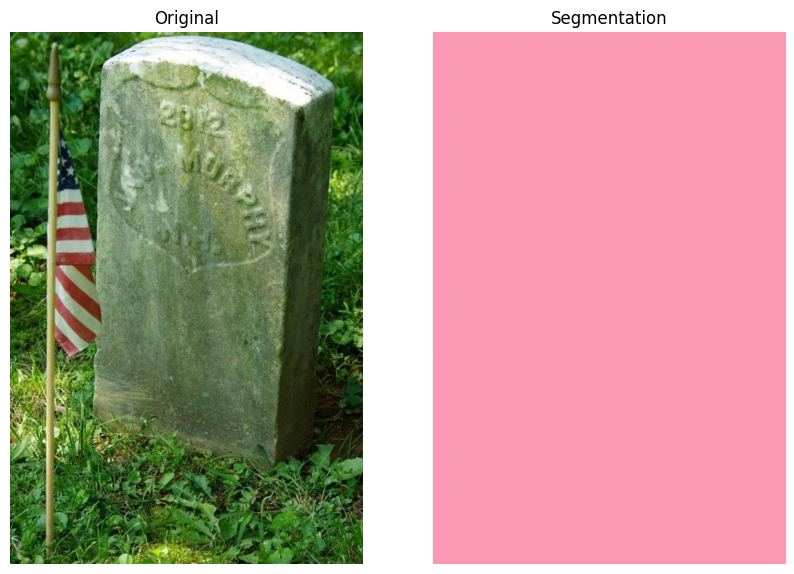

In [ ]:
def visualize_instance_seg_mask(mask):
    # Initialize image with zeros with the image resolution
    # of the segmentation mask and 3 channels
    image = np.zeros((mask.shape[0], mask.shape[1], 3))
    # Create labels
    labels = np.unique(mask)
    label2color = {
        label: (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )
        for label in labels
    }
    for height in range(image.shape[0]):
        for width in range(image.shape[1]):
            image[height, width, :] = label2color[mask[height, width]]
    image = image / 255
    return image
instance_seg_mask_disp = visualize_instance_seg_mask(instance_seg_mask)
plt.figure(figsize=(10, 10))
for plot_index in range(2):
    if plot_index == 0:
        plot_image = image
        title = "Original"
    else:
        plot_image = instance_seg_mask_disp
        title = "Segmentation"

    plt.subplot(1, 2, plot_index+1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

In [ ]:
# Load Mean IoU metric
metrics = evaluate.load("mean_iou")
# Set model in evaluation mode
model.eval()
# Test set doesn't have annotations so we will use the validation set
ground_truths, preds = [], []
for idx in tqdm(range(200)):
    image = validation[idx]["image"].convert("RGB")
    target_size = image.size[::-1]
    # Get ground truth semantic segmentation map
    annotation = np.array(validation[idx]["annotation"])[:,:,0]
    # Replace null class (0) with the ignore_index (255) and reduce labels
    annotation -= 1
    annotation[annotation==-1] = 255
    ground_truths.append(annotation)
    # Preprocess image
    inputs = processor(images=image, return_tensors="pt").to(device)
    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process results to retrieve semantic segmentation maps
    result = processor.post_process_semantic_segmentation(outputs, target_sizes=[target_size])[0]
    semantic_seg_mask = result.cpu().detach().numpy()
    preds.append(semantic_seg_mask)
results = metrics.compute(
    predictions=preds,
    references=ground_truths,
    num_labels=100,
    ignore_index=255
)
print(f"Mean IoU: {results['mean_iou']} | Mean Accuracy: {results['mean_accuracy']} | Overall Accuracy: {results['overall_accuracy']}")

  0%|          | 0/200 [00:00<?, ?it/s]

IndexError: Invalid key: 100 is out of bounds for size 100